# Fullscan Renders
Outputting the graphs of the data collected by running the robot :) This data is just for viewing purposes, there is a separate notebook for testing the pathfinder modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd

from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
path = os.path.abspath('..\\')
print("Available test files:")
file_itr = 0
while os.path.exists(path + "\\Scans\\test_%s.json" % file_itr):
    print("\t\\Scans\\test_%s.json" % file_itr)
    file_itr +=1
file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\test_%s.json" % file_itr):
    print("\t\\Debugging Scripts\\test_%s.json" % file_itr)
    file_itr +=1


Available test files:
	\Scans\test_0.json
	\Scans\test_1.json
	\Scans\test_2.json
	\Scans\test_3.json
	\Scans\test_4.json
	\Scans\test_5.json
	\Scans\test_6.json
	\Scans\test_7.json
	\Scans\test_8.json
	\Scans\test_9.json
	\Scans\test_10.json
	\Scans\test_11.json


In [55]:
debug_mode = True
save_figs = False
file_no = 11

if save_figs:
    plt.rcParams['figure.dpi'] = 500
else:
    plt.rcParams['figure.dpi'] = 200

In [57]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = r"\Scans\test_%s.json" % file_no
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

# print(json_data)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
max_point = json_data["max_point"]

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
    # print(point_mags[0])
    # print(max_point)
    # print(resolution)
    # print(r_o_m)

c:\Users\ander\Documents\COBOT-Transducer-Control-Code\Scans\test_11.json
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-6, 6], 'Rx': [0, 0], 'Ry': [-25, 25], 'Rz': [0, 0]}
resolution: [0.5, 0.5]
max_point: [[[0.0, 0.0, 4.5], [0.0, -1.5, 0.0]], 680.41]


In [58]:
# Zs = []
# Rxs = []
# Rys = []
# mags = []

# for p in point_mags:
#     Zs.append(p[0][0][2])
#     Rxs.append(p[0][1][0])
#     Rys.append(p[0][1][1])
#     mags.append(p[1])

# Gonna find the set of Rxs and Rys corresponding only to the Z value found at the max point
# Then do the same for the other guys
r = dict()
active_rom = []
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2
    if r[DoF] != 0.0:
        active_rom.append(DoF)

indeces = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
points = np.array([[p[0][indeces[a][0]][indeces[a][1]] for a in active_rom] for p in point_mags])
magss = np.array([[p[1] for p in point_mags]])
magss = magss.T

np_all = np.hstack((points,magss))

dat = pd.DataFrame(data = np_all, columns=["Z","R","mag"])
print(dat.head())
mp = dat.loc[dat['mag'].idxmax()]
print(mp)

     Z     R      mag
0 -6.0 -24.5  139.012
1 -6.0 -24.0   76.907
2 -6.0 -23.5   64.547
3 -6.0 -23.0   66.988
4 -6.0 -22.5   66.988
Z        4.50
R       -1.50
mag    680.41
Name: 2142, dtype: float64


Maximum magnitude:  680.41
Minimum magnitude: 59.511
Median magnitude: 69.43


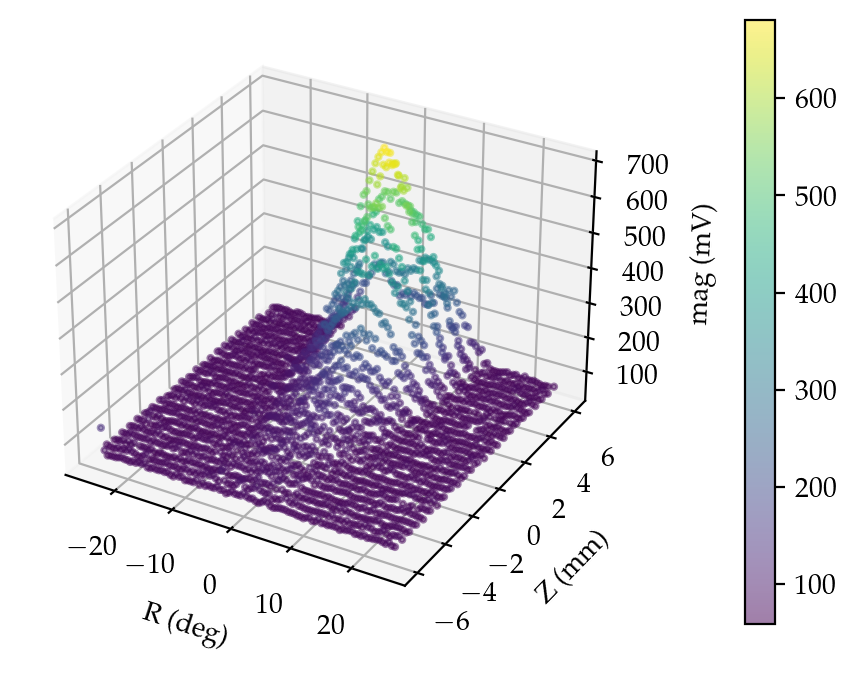

680.41


In [59]:
ax = plt.axes(projection='3d')

if debug_mode:
    print(f"Maximum magnitude:  {max(dat['mag'])}")
    print(f"Minimum magnitude: {min(dat['mag'])}")
    print(f"Median magnitude: {np.median(dat['mag'])}")

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

med = np.median(dat['mag'])
# dat2 = dat[np.all([dat['mag'] > med*1.3, dat['Ry'] > 5],axis=0)]
dat2 = dat[dat['mag'] > med*1.3]

# fig = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.1,s=4)
fig = ax.scatter(dat['R'], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.5,s=4)

ax.set_xlabel("R (deg)")
ax.set_ylabel("Z (mm)")
ax.set_zlabel("mag (mV)")

plt.colorbar(fig, pad=0.13)
if save_figs:
    plt.savefig("fullscan_render_test_%s.jpg" % file_no, dpi=400)
plt.show()

print(max(dat['mag']))


In [60]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']]
Rmps = dat[dat['R'] == mp['R']]

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of points array: {points.shape}")
    print(f"Shape of magnitudes array: {magss.shape} \n(Should be 1-D, same length as points array)")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

Active range of motion: ['Z', 'Ry']
Shape of points array: (2489, 2)
Shape of magnitudes array: (2489, 1) 
(Should be 1-D, same length as points array)
Tenth point_mag item (representative): [ -6.    -19.5    66.988]
Testing the Z-max-points array:
        Z     R     mag
2089  4.5  25.0  66.988
2090  4.5  24.5  69.430
2091  4.5  24.0  74.465
2092  4.5  23.5  69.430
(Should be all the same as in the maxpoint)
Maximum point: Z        4.50
R       -1.50
mag    680.41
Name: 2142, dtype: float64


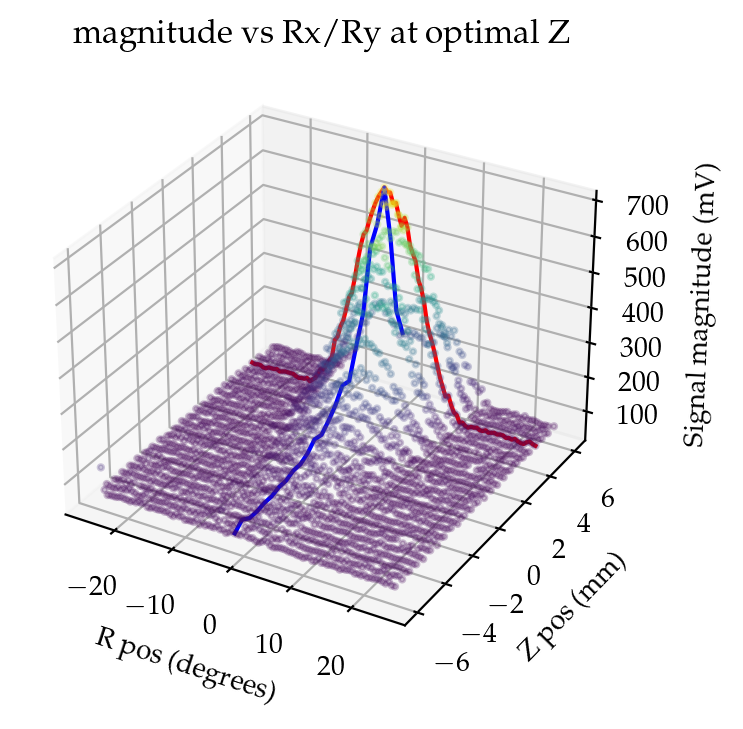

In [61]:
# fig2 = plt.figure(figsize=(14,4), constrained_layout=True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

# tax = fig2.add_subplot(1,3,1, projection='3d')
tax = plt.axes(projection='3d')
tax.scatter3D(dat['R'], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.25,s=4)
tax.plot3D(zmps['R'], zmps['Z'], zmps['mag'],c='r')
tax.plot3D(Rmps['R'], Rmps['Z'], Rmps['mag'],c='b')
tax.set_title("magnitude vs Rx/Ry at optimal Z")
tax.set_xlabel("R pos (degrees)")
tax.set_ylabel("Z pos (mm)")
tax.set_zlabel("Signal magnitude (mV)")

plt.show()

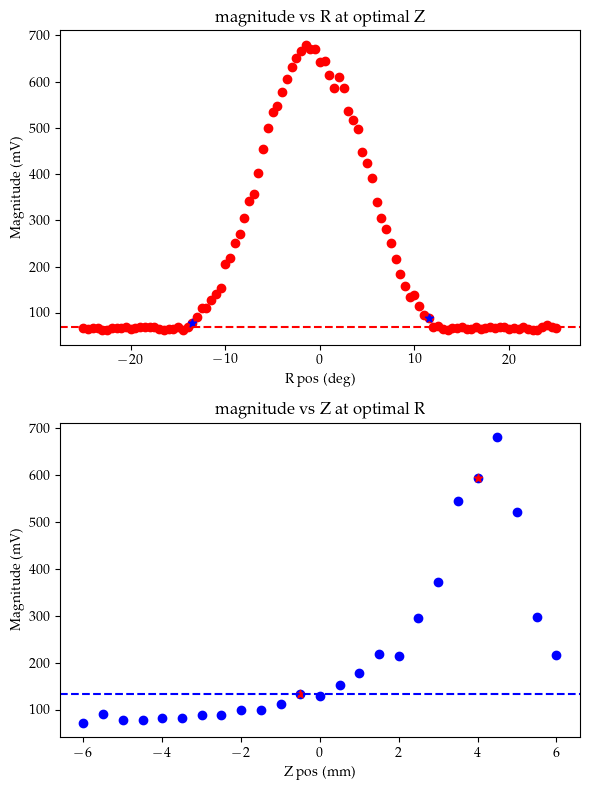

In [69]:
fig3 = plt.figure(figsize=(6,8), dpi=100)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)


tax = fig3.add_subplot(211)
tax.scatter(zmps['R'],zmps['mag'], c='r')

tax.axhline(np.median(dat['mag']), c='r',ls='--')
# tax.axhline(np.median(dat['mag']), c='r',ls='--')
# a = [16,64]
a = [27,77]
tax.scatter(zmps['R'].reset_index()['R'][a],zmps['mag'].reset_index()['mag'][a], c='b', marker='*')
tax.set_title("magnitude vs R at optimal Z")
tax.set_xlabel("R pos (deg)")
tax.set_ylabel("Magnitude (mV)")

tax = fig3.add_subplot(212)
tax.scatter(Rmps['Z'],Rmps['mag'], c='b')
tax.axhline(np.median(Rmps['mag']), c='b',ls='--')
# a = [25,45]
a=[11,20]
tax.scatter(Rmps['Z'].reset_index()['Z'][a],Rmps['mag'].reset_index()['mag'][a], c='r', marker='*')

tax.set_title("magnitude vs Z at optimal R")
tax.set_xlabel("Z pos (mm)")
tax.set_ylabel("Magnitude (mV)")

fig3.tight_layout()

[ 9.85947723e+03  1.58158303e+01  5.87839402e+00 -1.65858995e+01]


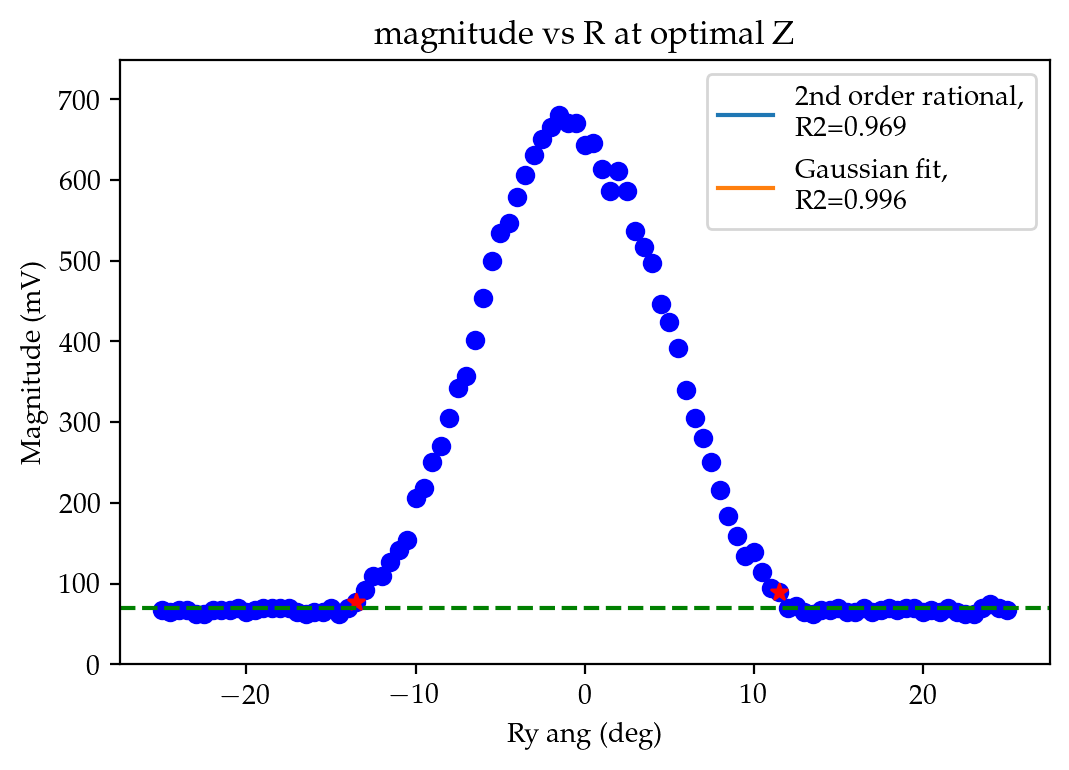

In [74]:
from scipy.optimize import curve_fit

fig4 = plt.axes()
fig4.get_figure().dpi=200

# interpolation_windows = {'Z': [25,45], 'R': [16,64]}
interpolation_windows = {'R': [27,77], 'Z': [11,20]}

t = {'Z': (Rmps, 'r', np.median(Rmps['mag']), 'g', \
    'magnitude vs Z at optimal R', "Z pos (mm)"), \
    'R': (zmps, 'b', np.median(zmps['mag']), 'r', \
    'magnitude vs R at optimal Z', "Ry ang (deg)")}

b = "R"
a = interpolation_windows[b]

fig4.scatter(t[b][0][b],t[b][0]['mag'], c=t[b][1])
fig4.scatter(t[b][0].reset_index()[b][a],t[b][0].reset_index()['mag'][a], c=t[b][3], marker='*')
fig4.axhline(np.median(dat['mag']), c='g',ls='--')

fig4.set_title(t[b][4])
fig4.set_xlabel(t[b][5])
fig4.set_ylabel("Magnitude (mV)")

def func(x, a, b, c):
    return (a*(x**2)) + (b*x) + c

def func1(x,a,b,c,d):
    return (d/((a*(x**2)) + (b*x) + c))

def func2(x,a,b,s,m):
    return (a / (s * np.sqrt(2 * np.pi))) * (np.e)**(-0.5 * (((x-b) - m)/s)**2)

# x = np.linspace(t[b][0].reset_index()[b][a[0]],t[b][0].reset_index()[b][a[1]])
x = np.linspace(t[b][0][b].reset_index()[b][0],max(t[b][0][b].reset_index()[b]),500)
# print(t[b][0].reset_index()[b][a[0]:a[1]])

# popt, pcov = curve_fit(func, t[b][0].reset_index()[b][a[0]:a[1]], t[b][0].reset_index()['mag'][a[0]:a[1]])
# fig4.plot(x, func(x, *popt), label="2nd order poly fit")

x_data = t[b][0].reset_index()[b][a[0]:a[1]]
y_data = t[b][0].reset_index()['mag'][a[0]:a[1]]

def r_squared(func, popt, x_dat, y_dat):
    residuals = y_dat - func(x_dat, *popt)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y_dat - np.mean(y_dat))**2)

    return 1 - (ss_res/ss_tot)

popt, pcov = curve_fit(func1, x_data, y_data)
fig4.plot(x, func1(x, *popt), label=f"2nd order rational,\n R2={r_squared(func1, popt, x_data, y_data):0.3f}")
popt, pcov = curve_fit(func2, x_data, y_data)
fig4.plot(x, func2(x, *popt), label=f"Gaussian fit,\n R2={r_squared(func2, popt, x_data, y_data):0.3f}")

print(popt)
# print(func(x, *popt))

# fig4.legend(bbox_to_anchor=(1.56, 1.023))
fig4.legend()
fig4.set_ybound([0, t[b][0]['mag'].max() * 1.1])

# odr.polynomial?